# Lab 3: Clustering, Association Rules, or Recommendors
Grace Lang, Michael Hedge, Paul Huggins, Morgan Nelson

## Business Understanding: 
The dataset identifies customers' case of defaulting on credit card payments in Taiwan. It contains six months of banking transactions for customers (April 2005 to September 2005) to answer the question: did the customer default or not?

By reviewing past spending and payment patterns, the bank has the opportunity to reduce a user's credit limit, which could reduce the overall outstanding credit that would be defaulted.

In this clustering analysis we will not use the data in order to solve a binary logistic regression or multiclassification model. Instead we will try to gain an understanding of the users that default versus those that do not. We will then take into account the learnings into our recommended deployment in either a marketing campaign or an operations, customer management system. There is very little evaluation metrics that we can use in order to determine if a cluster analysis makes sense. However, we will be able to leverage PCA in order to understand if there is an ability to have a clear distinction amongst the groups. We can also leverage SSE Metric, WCSS and Silhoutte Scores to determine the proper number of clusters. Lastly, and most importantly, we will use our business domain knowledge in order to understand if the clusters that the model creates make sense for application and deployment of a marketing or operational strategy. These validations align with the bank's needs because while we were given a limited dataset, we have to be able to curate insights from the data that is available. 

#### Load libraries

In [1]:
import pandas as pd
import pandas_profiling as pp
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.colors as colors
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import datasets
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from pycaret.classification import *
from sklearn import preprocessing
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
from statsmodels.api import add_constant
from scipy.stats import norm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from xgboost import plot_tree
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from numpy import unique
from numpy import where

import logging, sys
logging.disable(sys.maxsize)

%matplotlib inline

# Data Preparation: 

Defining Variables & Feature Engineering (Prior Lab work):

In [2]:
#Setting Color Scheme for plots
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# Source code for colors : https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/11784589

# Read in data
credit = pd.read_csv("../credit_defaults.csv")

# Change column types
credit = credit.astype({
    "SEX": float, 
    "EDUCATION": float, 
    "MARRIAGE": float, 
    "PAY_0": float,
    "PAY_2": float,
    "PAY_3": float,
    "PAY_4": float,
    "PAY_5": float,
    "PAY_6": float,
    "BILL_AMT1":float,
    "BILL_AMT2":float,
    "BILL_AMT3":float,
    "BILL_AMT4":float,
    "BILL_AMT5":float,
    "BILL_AMT6":float,
    "PAY_AMT1":float,
    "PAY_AMT2":float,
    "PAY_AMT3":float,
    "PAY_AMT4":float,
    "PAY_AMT5":float,
    "PAY_AMT6":float
})

# Recode education values
fill = (credit.EDUCATION == 0) | (credit.EDUCATION == 5) | (credit.EDUCATION == 6)
credit.loc[fill, 'EDUCATION'] = 4

# Rename default and Pay_0 column
credit = credit.rename(columns={'default payment next month': 'DEFAULT', 
                        'PAY_0': 'PAY_1'})

# Drop outlier rows found in Lab 1
credit.drop(credit[(credit['PAY_1'] == -2) & (credit['PAY_2'] == -2) & (credit['PAY_3'] == -2) & (credit['PAY_4'] == -2) & (credit['PAY_5'] == -2) & (credit['PAY_6'] == -2) & 
                   (credit['BILL_AMT1'] == 0) & (credit['BILL_AMT2'] == 0) & (credit['BILL_AMT3'] == 0) & (credit['BILL_AMT4'] == 0) & (credit['BILL_AMT5'] == 0) & (credit['BILL_AMT6'] == 0) & 
                   (credit['DEFAULT'] == 1)].index, inplace = True)

# Changing DEFAULT to BOOL
credit.DEFAULT = credit.DEFAULT.astype(bool)
#print (credit.info())

# Log Transforming LIMIT_BAL
credit['LOG_BAL'] = np.log(credit['LIMIT_BAL']) 

# Average balance of their billing account for 5 months 
credit['BILL_AMT_AVG'] = (credit[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1))/6

# Average payment amount for 5 months
credit['PAY_AMT_AVG'] = (credit[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].sum(axis=1))/6

# Percent of monthly avg credit balance to their credit limit
credit['PER_CRED_LIMIT_BAL'] = (credit['BILL_AMT_AVG']/credit['LIMIT_BAL'])

# Remove ID column.
del credit['ID']

## Normalizing and transforming data for analysis
The data needed to be transformed for analysis.
Prior lab work.

In [3]:
# Define dataset used for clustering
df = credit
df2 = credit
col_names = df2.columns.tolist() # saving these for later when we combine the dataets

# scale df
scl_obj = StandardScaler()
scl_obj.fit(df)
df = scl_obj.transform(df)

# normalize and convert to dataframe
df = normalize(df)
df = pd.DataFrame(df)

# Dataset Description:

The dataset consists of 30,000 rows with 25 variables described below. NT dollars = New Taiwan dollars, which is equivalent to 32 NT dollars to 1 United States Dollar in 2005. The definitions of the data fields were explained using the UCI data description in addition to discussion notes from the original teacher who posted the data source on kaggle. 

__Nominal:__
* ID: ID of each client (unique ordinal) 
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school; 0,4,5,6=others)
* MARRIAGE: Marital status (1=married, 2=single, 3=divorce & 4=others)
* AGE: Age in years

__Scale:__
* PAY_1: Repayment status in September, 2005 
    + -2: No consumption 
    + -1: Paid in full 
    + 0: The use of revolving credit 
    + 1 = payment delay for one month
    + 2 = payment delay for two months
    + . . . 8 = payment delay for eight months
    + 9 = payment delay for nine months and above)
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)

__Discrete:__
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

__Binary:__
* DEFAULT: Default payment (1=yes, 0=no)

__Additional Feature Engineering:__
* BILL_AMT_AVG: Average balance of their billing account for 5 months 
* PAY_AMT_AVG: Average payment amount for 5 months
* PER_CRED_LIMIT_BAL: Percent of monthly avg credit balance to their credit limit
* LOG_BAL: Log transformation of LIMIT_BAL

### Data Outliers
There were 108 records that were identified as outliers. These outliers did not meet the basic business rules because these records had no billing balance within the 5 months of data reported; however, these users defaulted. If there was any prior billing balance outside of these 5 months, the data governance would imply that the billing balance would be compounded with interest into the next month's billing cycle. Having a credit balance of zero with a flag of having to default because the user made no payments does not make business sense. These 108 records are potentially erroneous; however, there is not a data point of contact to resolve this outstanding question. Removing these questionable observations from any future modeling will help the models be able to more accurately determine when a user may default. 

### Missing & Duplicate Data
No missing data fields was observed. There were also no duplicate values based on ID number.

### Visualizations of Important Attributes
The dataset is made up of 22% of users who defaulted on their credit card. 

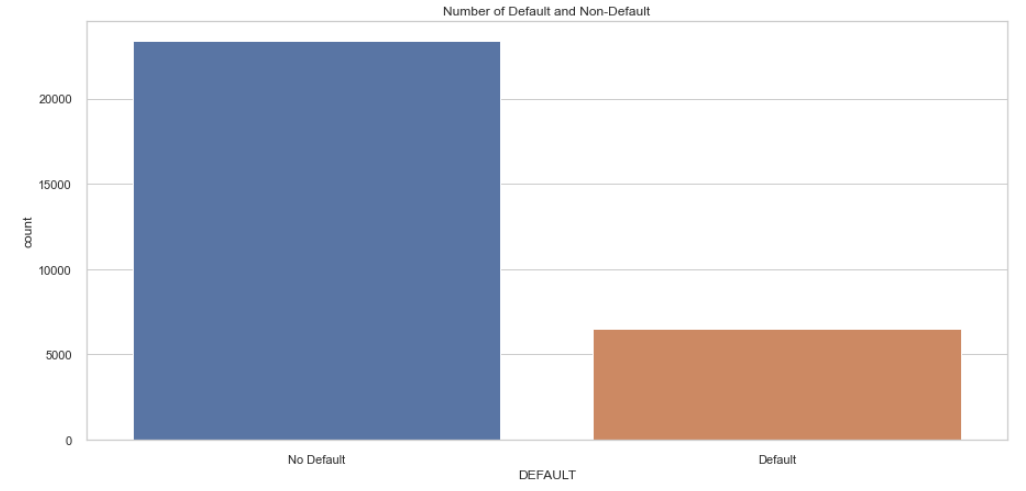

In [5]:
Image("../img/Default.png")

From our binary & multiclassification models the top 5 features were pulled out of the winning models and noted below:

Feature|Random Forest Binary Class|Random Forest Multi-Class|
--|----|----|
1|PAY_1|LIMIT_BAL|
2|PAY_2|PAY_1|
3|EDUCATION|PER_CREDIT_LIMIT_BAL|
4|MARRIAGE|PAY_2|
5|SEX|BILL_AMT1|

When considering clustering, we weighed how our predictive models stacked up to how the fields were presented in each of the clusters. More of these data visualizations can be seen the EDA Tableau notebook (*Lab3_ML1_Original_3Cluster*). 

---

### For the clustering algorithms, SSE and Silhoutte scores were used to judge the cohesiveness of the clusters.
##### Error Sum of Squares (SSE) is the sum of the squared differences between each observation and its group's mean.
##### The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

---

# Modeling & Evaluation: Combining PCA & KMeans
Source: https://365datascience.com/pca-k-means/

We needed to determine the ideal number of PCA's to explain around 80% of the varaince.

The variance ratios are printed below, purely for reference.

In [4]:
# Generate and View the PCA's
pca = PCA()
pca.fit(df)
pca.explained_variance_ratio_

array([2.63379523e-01, 1.65637490e-01, 9.97339928e-02, 7.17437294e-02,
       7.09604915e-02, 5.15172223e-02, 4.64884388e-02, 3.55386688e-02,
       3.30721740e-02, 2.71708480e-02, 2.04821409e-02, 1.47732618e-02,
       1.24919239e-02, 1.23127694e-02, 1.15221574e-02, 1.12694486e-02,
       1.06127126e-02, 1.00553417e-02, 8.35013073e-03, 7.48840210e-03,
       6.62761126e-03, 4.16476264e-03, 2.07125969e-03, 1.15878585e-03,
       7.56841329e-04, 6.19871787e-04, 1.27226364e-31, 1.92815359e-32])

Plotting the PCA's will provide insight into how many PCA's explain 80% of the variance.

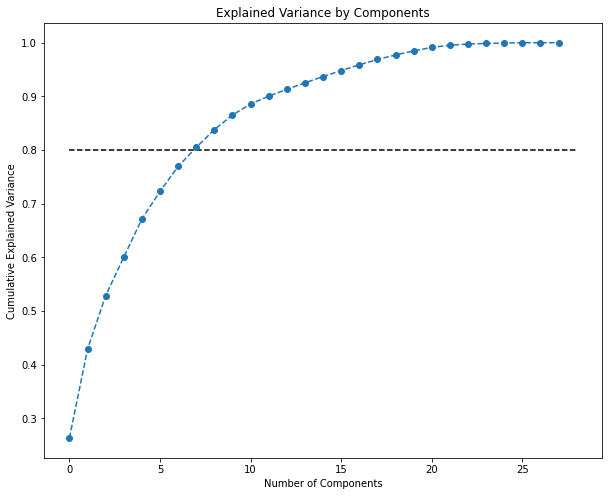

In [5]:
# Plot the Explained Variance by PCA. Targeting 80% explained variance
plt.figure(figsize = (10,8))
plt.plot(range(0,28), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(0.8,0,28, colors = 'k', linestyle = '--') # hline at 80% varaince

8 PCA's appears to explain roughly 80% of the variance.

Next, the data is reduced down to 8 PCA's. We plotted these PCAs in the Tableau EDA workbook (*Lab3_ML1_Original_3Cluster*), which gave us some understanding that we could draw a clear distinction for 3 clusters with PC1 versus PC2. While we do not use the PCAs in our final model because the are difficult to interpret, we used them as a preliminary validation to ensure our clusters had clear seperation. 

In [6]:
# Reducing the dimensions of the data down to 8
pca = PCA(n_components = 8, random_state = 123) 
X_principal = pca.fit_transform(df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
print(pca.fit)
print(X_principal.head(8))

<bound method PCA.fit of PCA(n_components=8, random_state=123)>
         P1        P2        P3        P4        P5        P6        P7  \
0 -0.191631 -0.451689  0.099422  0.092793 -0.101396  0.556812 -0.057349   
1 -0.014390 -0.396904 -0.209330  0.492896  0.047696  0.205552  0.223785   
2 -0.238059 -0.555746 -0.282535  0.238954 -0.318957 -0.264878  0.213365   
3  0.316163 -0.434467  0.374933 -0.098430 -0.526189 -0.141454 -0.388003   
4 -0.114059 -0.145297  0.605007 -0.255784  0.237788 -0.242596 -0.188586   
5  0.288337 -0.398012 -0.266265 -0.434964  0.351559 -0.172964 -0.392823   
6  0.647482  0.768875 -0.134268 -0.221953  0.013210  0.099174 -0.011488   
7 -0.535269 -0.365332 -0.406765  0.084233 -0.276708 -0.086033  0.189059   

         P8  
0 -0.305664  
1 -0.002761  
2  0.269080  
3 -0.070659  
4  0.304123  
5  0.241516  
6 -0.025968  
7 -0.121262  


## Determining ideal number of clusters based on 8 PCA's

SSE Metric, WCSS and Silhoutte Scores were all ran to narrow down the ideal number of clusters. Three clusters was determined to be the best based on all three evaluation metrics. We also observed the results of 2 and 5 clusters, which we also ran our analysis through. Ultimately we decided to stay with the 3 clusters for easy of use and to show our client a preliminary proof-of-concept, so that we can go back and ask for more data (ie. customer profile information, credit transaction history, FICO scores, etc.). More of the evaluation of the 2 metrics will be in the final conclusion. 

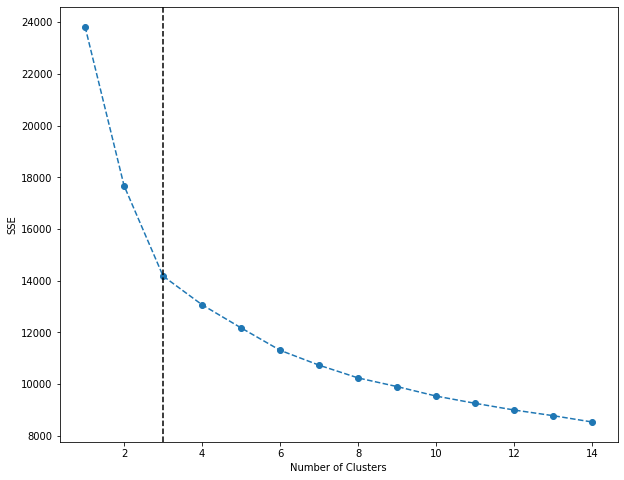

In [7]:
from sklearn.cluster import KMeans

# SSE Metric plot
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state = 123)
    kmeans.fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize = (10,8))
plt.plot(list(sse.keys()), list(sse.values()), marker = 'o', linestyle = '--')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.axvline(x=3, linestyle = '--', color = 'k') # 3 clusters is ideal per the elbow method
plt.show()

Based on the 'Elbow' method, there appears to be 3 distinct clusters within the Kmeans/PCA dataset.

### Build KMeans Model on 3 clsuters

In [8]:
# Create Model
kmeans_pca = KMeans(n_clusters=3, init = 'k-means++', random_state = 123)
kmeans_pca.fit(X_principal)
print(kmeans_pca)

# assign a cluster to each example
yhat = kmeans_pca.predict(X_principal)

# retrieve unique clusters
clusters = unique(yhat)
print(clusters) # 3 unique

KMeans(n_clusters=3, random_state=123)
[0 1 2]


### KMeans with PCA Results

In [9]:
# Combine original dataframe with the PC's and cluster designation! Here's the magic! Woot!
pca_km_org_df = pd.concat([credit.reset_index(drop=True), pd.DataFrame(X_principal)], axis = 1) # Used Credit here instead of df to get orignal untransformed/normalzed values. Better for interpretaion, no effect on output.
pca_km_org_df.columns.values[-8: ] = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']
pca_km_org_df['PCA Cluster'] = yhat

# Rename and tidy cluster column
pca_km_org_df['Cluster'] = pca_km_org_df['PCA Cluster'].map({0:'First',
                                                     1:"Second",
                                                     2:"Third"})

# write out to csv for Tableau visuals
column_ind = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
new_names = col_names
old_names = pca_km_org_df.columns[column_ind]
pca_km_org_df.rename(columns=dict(zip(old_names, new_names)), inplace = True)
pca_km_org_df.to_csv(("../pca-km-org-df.csv"))

print(pca_km_org_df.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0    20000.0  2.0        2.0       1.0   24    2.0    2.0   -1.0   -1.0   
1   120000.0  2.0        2.0       2.0   26   -1.0    2.0    0.0    0.0   
2    90000.0  2.0        2.0       2.0   34    0.0    0.0    0.0    0.0   
3    50000.0  2.0        2.0       1.0   37    0.0    0.0    0.0    0.0   
4    50000.0  1.0        2.0       1.0   57   -1.0    0.0   -1.0    0.0   

   PAY_5  ...       PC1       PC2       PC3       PC4       PC5       PC6  \
0   -2.0  ... -0.191631 -0.451689  0.099422  0.092793 -0.101396  0.556812   
1    0.0  ... -0.014390 -0.396904 -0.209330  0.492896  0.047696  0.205552   
2    0.0  ... -0.238059 -0.555746 -0.282535  0.238954 -0.318957 -0.264878   
3    0.0  ...  0.316163 -0.434467  0.374933 -0.098430 -0.526189 -0.141454   
4    0.0  ... -0.114059 -0.145297  0.605007 -0.255784  0.237788 -0.242596   

        PC7       PC8  PCA Cluster  Cluster  
0 -0.057349 -0.305664            1   Sec

In [10]:
# Combine transformed dataframe with the PC's and cluster designation! Here's the magic! Woot!
pca_km_trf_df = pd.concat([df.reset_index(drop=True), pd.DataFrame(X_principal)], axis = 1) # Used Credit here instead of df to get orignal untransformed/normalzed values. Better for interpretaion, no effect on output.
pca_km_trf_df.columns.values[-8: ] = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']
pca_km_trf_df['PCA Cluster'] = yhat

# Rename and tidy cluster column
pca_km_trf_df['Cluster'] = pca_km_trf_df['PCA Cluster'].map({0:'First',
                                                     1:"Second",
                                                     2:"Third"})

# write out to csv for Tableau visuals
column_ind = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
new_names = col_names
old_names = pca_km_trf_df.columns[column_ind]
pca_km_trf_df.rename(columns=dict(zip(old_names, new_names)), inplace = True)
pca_km_trf_df.to_csv(("../pca-km-trf-df.csv"))

print(pca_km_trf_df.head())

   LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE     PAY_1     PAY_2  \
0  -0.213124  0.152247   0.039678 -0.198728 -0.233888  0.337225  0.334643   
1  -0.083991  0.187453   0.048853  0.198459 -0.237766 -0.204647  0.412026   
2  -0.285846  0.389647   0.101548  0.412524 -0.076791  0.004095  0.051147   
3  -0.375871  0.337310   0.087908 -0.440291  0.069037  0.003545  0.044277   
4  -0.232728 -0.317984   0.054430 -0.272615  0.602117 -0.228010  0.027415   

      PAY_3     PAY_4     PAY_5  ...       PC1       PC2       PC3       PC4  \
0 -0.132239 -0.126563 -0.289177  ... -0.191631 -0.451689  0.099422  0.092793   
1  0.030915  0.042487  0.053187  ... -0.014390 -0.396904 -0.209330  0.492896   
2  0.064261  0.088315  0.110557  ... -0.238059 -0.555746 -0.282535  0.238954   
3  0.055629  0.076452  0.095707  ...  0.316163 -0.434467  0.374933 -0.098430   
4 -0.181405  0.047337  0.059259  ... -0.114059 -0.145297  0.605007 -0.255784   

        PC5       PC6       PC7       PC8  PCA Cluster  

A PC plot was constructed to visualze a sample of the data and then the bulk of the work was done in Tableau (*Lab3_ML1_Original_3Cluster*).

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


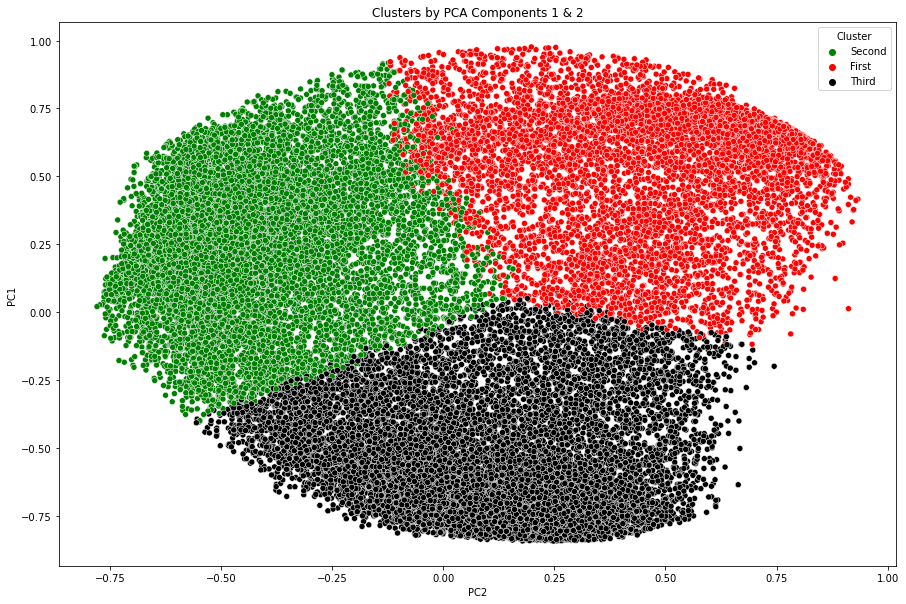

In [11]:
# Plotting some of the results
x_ax = pca_km_trf_df['PC2']
y_ax = pca_km_trf_df['PC1']
plt.figure(figsize = (15,10))
sns.scatterplot(x_ax, y_ax, hue = pca_km_trf_df['Cluster'], palette = ['g', 'r', 'k'])
plt.title('Clusters by PCA Components 1 & 2')
plt.show()

---

### Agglomerative Clustering:
Agglomerative clustering (also called (Hierarchical Agglomerative Clustering, or HAC)) is a “bottom up” type of hierarchical clustering. In this type of clustering, each data point is defined as a cluster. Pairs of clusters are merged as the algorithm moves up in the hierarchy. Each document is treated as an indivudiaul at the bottom of the tree and then merged on commonalities as the tree grows upwards to form clusters.

__First Step:__ We need to determine the optimal number of clusters to generate.

#### Option 1 - Dendogram
The dendogram led us to believe that there are 2 strong clusters and then a third that might contain fewer records. 

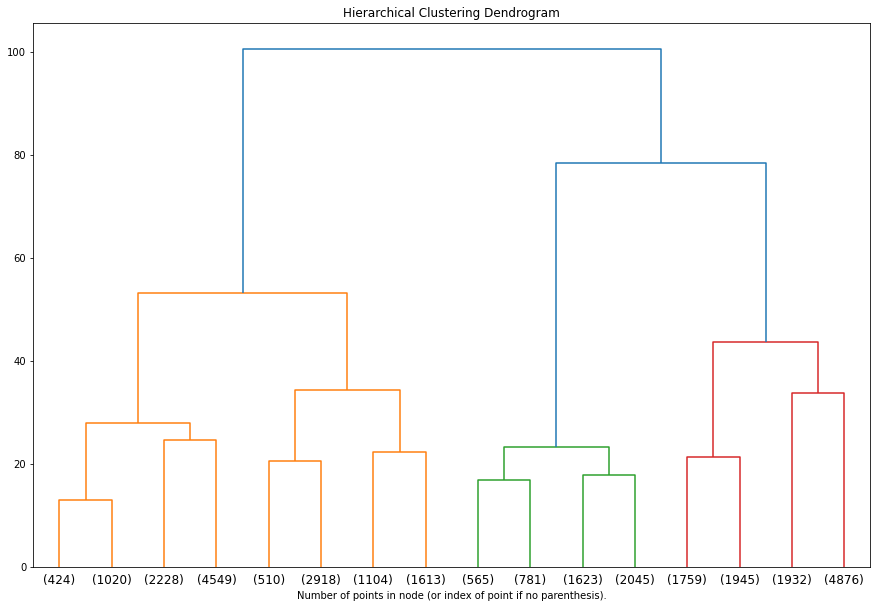

In [13]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df)
plt.figure(figsize = (15,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Source code: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
# Knowledge code: https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
# Knowledge code: https://www.statisticshowto.com/agglomerative-clustering/

#### Option 2 - Silhoutte Scores
The Silhoutte scores show us that 3 clusters provides the best results going forward.

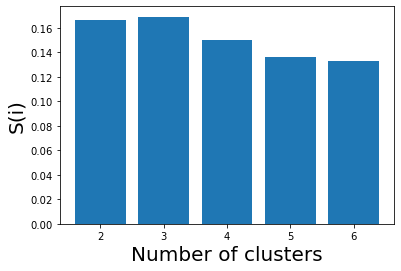

In [14]:
ac2 = AgglomerativeClustering(n_clusters = 2) 
ac3 = AgglomerativeClustering(n_clusters = 3) 
ac4 = AgglomerativeClustering(n_clusters = 4) 
ac5 = AgglomerativeClustering(n_clusters = 5) 
ac6 = AgglomerativeClustering(n_clusters = 6)

k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append(silhouette_score(df, ac2.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, ac3.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, ac4.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, ac5.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, ac6.fit_predict(df))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

# Source code: https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

While the Silhouette scores are lower overall than we would like, 3 clusters provides the highest among the group.

In [8]:
from numpy import unique
from numpy import where
from sklearn.cluster import AgglomerativeClustering

# create agg dataset
df_agg = df

# define the model
model = AgglomerativeClustering(n_clusters = 3)

# fit model and predict clusters
yhat = model.fit_predict(df_agg)

# retrieve unique numbmer of clusters
clusters = unique(yhat)
print("Clusters: ", clusters)

# add cluster do dataset
df_agg["Cluster"] = yhat
print(df_agg.head())

# agglomerative clusters found 2 clusters

Clusters:  [0 1 2]
          0         1         2         3         4         5         6  \
0 -0.213124  0.152247  0.039678 -0.198728 -0.233888  0.337225  0.334643   
1 -0.083991  0.187453  0.048853  0.198459 -0.237766 -0.204647  0.412026   
2 -0.285846  0.389647  0.101548  0.412524 -0.076791  0.004095  0.051147   
3 -0.375871  0.337310  0.087908 -0.440291  0.069037  0.003545  0.044277   
4 -0.232728 -0.317984  0.054430 -0.272615  0.602117 -0.228010  0.027415   

          7         8         9  ...        19        20        21        22  \
0 -0.132239 -0.126563 -0.289177  ... -0.055866 -0.057987 -0.059130 -0.055220   
1  0.030915  0.042487  0.053187  ... -0.055669 -0.056655 -0.072804 -0.042010   
2  0.064261  0.088315  0.110557  ... -0.115717 -0.117766 -0.119915 -0.006321   
3  0.055629  0.076452  0.095707  ... -0.095454 -0.099295 -0.101931 -0.098968   
4 -0.181405  0.047337  0.059259  ...  0.069490  0.068263 -0.069512 -0.065924   

         23        24        25        26        

---

# BIRCH
Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH) is a clustering algorithm that can cluster large datasets by first generating a small and compact summary of the the large dataset that retains as much information as possible. This smaller summary is then clustered instead of clustering the larger dataset. One drawback is that BIRCH does not work with categorical variables. Our original transformations and scaling remedied this. BIRCH identified 3 clusters as the best fit. 

In [16]:
from sklearn.cluster import Birch

# create birch dataset
df_bir = df

# define the model
model = Birch()

# fit the model
model.fit(df_bir)

# assign a cluster to each example
yhat = model.predict(df_bir)

# retrieve unique clusters
clusters = unique(yhat)
print("Clusters: ", clusters)

# add cluster do dataset
df_bir["Cluster"] = yhat
print(df_bir.head())

# 3 clusters are created from the BIRCH method

Clusters:  [0 1 2]
          0         1         2         3         4         5         6  \
0 -0.213124  0.152247  0.039678 -0.198728 -0.233888  0.337225  0.334643   
1 -0.083991  0.187453  0.048853  0.198459 -0.237766 -0.204647  0.412026   
2 -0.285846  0.389647  0.101548  0.412524 -0.076791  0.004095  0.051147   
3 -0.375871  0.337310  0.087908 -0.440291  0.069037  0.003545  0.044277   
4 -0.232728 -0.317984  0.054430 -0.272615  0.602117 -0.228010  0.027415   

          7         8         9  ...        19        20        21        22  \
0 -0.132239 -0.126563 -0.289177  ... -0.055866 -0.057987 -0.059130 -0.055220   
1  0.030915  0.042487  0.053187  ... -0.055669 -0.056655 -0.072804 -0.042010   
2  0.064261  0.088315  0.110557  ... -0.115717 -0.117766 -0.119915 -0.006321   
3  0.055629  0.076452  0.095707  ... -0.095454 -0.099295 -0.101931 -0.098968   
4 -0.181405  0.047337  0.059259  ...  0.069490  0.068263 -0.069512 -0.065924   

         23        24        25        26        

---

# DBSCAN

### Before we do DBSCAN, we need to estimate eps and minPoints:
minPoints: the minimum number of points to form a dense region. For minPoints, we set it at 54 (27 features * 2). This value was plugged into KNN to determine the next metric.

eps: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered to be neighbors. For eps, a plot was created and the value at the eblow was used. DBSCAN identified 13 clusters as best fit. 

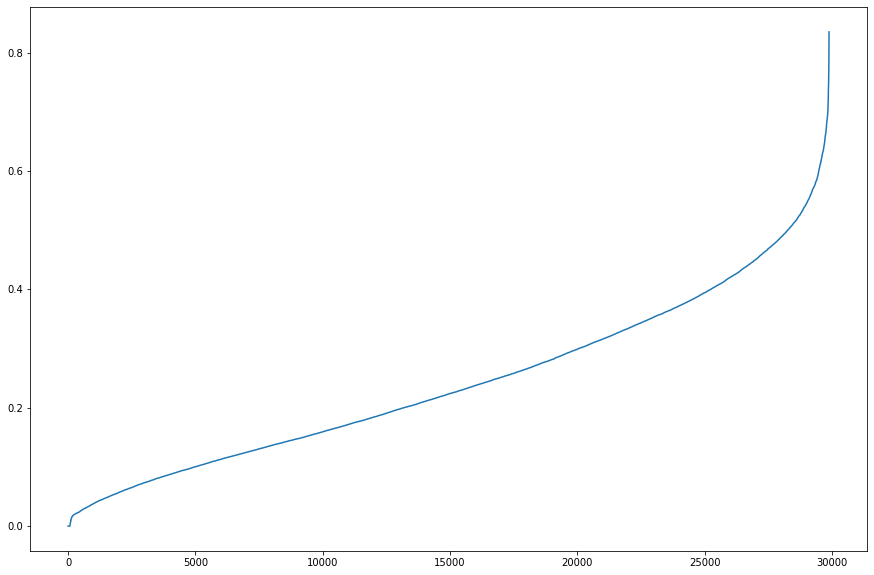

In [9]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=54) # 27 vars * 2 = 54
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize = (15,10))
plt.plot(distances)

# eps will be roughly 0.5 from the elbow on the curve.

Using the 'Elbow' method, the curve appears to be at around 0.5 This number will be used as eps in the dbscan algorithm.

In [10]:
from sklearn.cluster import DBSCAN

# create dbs dataset
df_dbs = df

# define the model
model = DBSCAN(eps = 0.5, min_samples = 54) # 0.5 for eps from above and 27*2 for min_samples

# fit the model
yhat = model.fit_predict(df_dbs)

# retrieve unique clusters
clusters = unique(yhat)
print("Clusters: ", clusters)

# add cluster do dataset
df_dbs["Cluster"] = yhat
print(df_dbs.head())

# dbscan found 11 - 13 clusters depending on the run.

Clusters:  [-1  0  1  2  3  4  5  6  7  8  9]
          0         1         2         3         4         5         6  \
0 -0.213124  0.152247  0.039678 -0.198728 -0.233888  0.337225  0.334643   
1 -0.083991  0.187453  0.048853  0.198459 -0.237766 -0.204647  0.412026   
2 -0.285846  0.389647  0.101548  0.412524 -0.076791  0.004095  0.051147   
3 -0.375871  0.337310  0.087908 -0.440291  0.069037  0.003545  0.044277   
4 -0.232728 -0.317984  0.054430 -0.272615  0.602117 -0.228010  0.027415   

          7         8         9  ...        19        20        21        22  \
0 -0.132239 -0.126563 -0.289177  ... -0.055866 -0.057987 -0.059130 -0.055220   
1  0.030915  0.042487  0.053187  ... -0.055669 -0.056655 -0.072804 -0.042010   
2  0.064261  0.088315  0.110557  ... -0.115717 -0.117766 -0.119915 -0.006321   
3  0.055629  0.076452  0.095707  ... -0.095454 -0.099295 -0.101931 -0.098968   
4 -0.181405  0.047337  0.059259  ...  0.069490  0.068263 -0.069512 -0.065924   

         23        24 

In [19]:
# Combine original dataframe with the dbscan and cluster designation! Here's the magic! Woot!
dbscan_df = pd.concat([credit.reset_index(drop=True), pd.DataFrame(df_dbs)], axis = 1) # Used Credit here instead of df to get orignal untransformed/normalzed values. Better for interpretaion, no effect on output.
dbscan_df['PCA Cluster'] = yhat

# write out to csv for Tableau visuals
column_ind = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
new_names = col_names
old_names = dbscan_df.columns[column_ind]
dbscan_df.rename(columns=dict(zip(old_names, new_names)), inplace = True)
dbscan_df.to_csv(("../dbscan_df.csv"))

print(dbscan_df.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0    20000.0  2.0        2.0       1.0   24    2.0    2.0   -1.0   -1.0   
1   120000.0  2.0        2.0       2.0   26   -1.0    2.0    0.0    0.0   
2    90000.0  2.0        2.0       2.0   34    0.0    0.0    0.0    0.0   
3    50000.0  2.0        2.0       1.0   37    0.0    0.0    0.0    0.0   
4    50000.0  1.0        2.0       1.0   57   -1.0    0.0   -1.0    0.0   

   PAY_5  ...        20        21        22        23        24        25  \
0   -2.0  ... -0.057987 -0.059130 -0.055220  0.355399 -0.350664 -0.130120   
1    0.0  ... -0.056655 -0.072804 -0.042010  0.437581  0.008614 -0.154502   
2    0.0  ... -0.117766 -0.119915 -0.006321 -0.254139 -0.129063 -0.214116   
3    0.0  ... -0.099295 -0.101931 -0.098968 -0.220003 -0.371678 -0.043279   
4    0.0  ...  0.068263 -0.069512 -0.065924 -0.136219 -0.230132 -0.109553   

         26        27  Cluster  PCA Cluster  
0 -0.095851 -0.165641    First          

---

# K-Means
To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids.

It halts creating and optimizing clusters when either:
* The centroids have stabilized — there is no change in their values because the clustering has been successful.
* OR, The defined number of iterations has been achieved.

*Knowledge: https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1*

In [20]:
from sklearn.cluster import KMeans

km2 = KMeans(n_clusters = 2) 
km3 = KMeans(n_clusters = 3) 
km4 = KMeans(n_clusters = 4) 
km5 = KMeans(n_clusters = 5) 
km6 = KMeans(n_clusters = 6)
km7 = KMeans(n_clusters = 7)
km8 = KMeans(n_clusters = 8)

k = [2, 3, 4, 5, 6, 7, 8, 9, 10] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append(silhouette_score(df, km2.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, km3.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, km4.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, km5.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, km6.fit_predict(df)))
silhouette_scores.append(silhouette_score(df, km7.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, km8.fit_predict(df))) 

print(silhouette_scores)

# 2 clusters provides the highest silhoutte scores
# Source code: https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

[0.739934464662829, 0.37139765391729124, 0.306422842486552, 0.31790625449099, 0.30209224349546027, 0.3030718669465184, 0.2873144635646764]


Note: 0.739 is the highest silhouette score we've seen among the models. Indicating the best defined clusters.

## Create the kmeans model from 2 clusters

In [21]:
# create km dataset
df_km = df

# define the model
model = KMeans(n_clusters = 2)

# fit the model
model.fit(df_km)

# assign a cluster to each example
yhat = model.predict(df_km)

# retrieve unique clusters
clusters = unique(yhat)
print("Clusters: ", clusters)

# add cluster do dataset
df_km["Cluster"] = yhat
print(df_km.head())

# kmeans with 2 clusters

Clusters:  [0 1]
          0         1         2         3         4         5         6  \
0 -0.213124  0.152247  0.039678 -0.198728 -0.233888  0.337225  0.334643   
1 -0.083991  0.187453  0.048853  0.198459 -0.237766 -0.204647  0.412026   
2 -0.285846  0.389647  0.101548  0.412524 -0.076791  0.004095  0.051147   
3 -0.375871  0.337310  0.087908 -0.440291  0.069037  0.003545  0.044277   
4 -0.232728 -0.317984  0.054430 -0.272615  0.602117 -0.228010  0.027415   

          7         8         9  ...        19        20        21        22  \
0 -0.132239 -0.126563 -0.289177  ... -0.055866 -0.057987 -0.059130 -0.055220   
1  0.030915  0.042487  0.053187  ... -0.055669 -0.056655 -0.072804 -0.042010   
2  0.064261  0.088315  0.110557  ... -0.115717 -0.117766 -0.119915 -0.006321   
3  0.055629  0.076452  0.095707  ... -0.095454 -0.099295 -0.101931 -0.098968   
4 -0.181405  0.047337  0.059259  ...  0.069490  0.068263 -0.069512 -0.065924   

         23        24        25        26        27

We combined the datasets and exported to Tableau to perform analysis on 2, 3, & 5 clusters. We will only discuss 2 & 3 clusters in our conclusions because we found that the 5 clusters were skewed and difficult to get a grasp on the nuanced differences between each cluster. Some clusers looked fairly similar, so we continued with 2 & 3 clusters because they were easier to present to the bank for a proposed marketing/operational campaign. 

In [22]:
# Combine original dataframe with the PC's and cluster designation! Here's the magic! Woot!
km_trf_df = pd.concat([credit.reset_index(drop=True), pd.DataFrame(df_km)], axis = 1) # Used Credit here instead of df to get orignal untransformed/normalzed values. Better for interpretaion, no effect on output.
km_trf_df['Cluster'] = yhat

# Rename and tidy cluster column
km_trf_df['Cluster'] = km_trf_df['Cluster'].map({0:"First",
                                                     1:"Second"})

# write out to csv for Tableau visuals
column_ind = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
new_names = col_names
old_names = km_trf_df.columns[column_ind]
km_trf_df.rename(columns=dict(zip(old_names, new_names)), inplace = True)
km_trf_df.to_csv(("../km-trf-df.csv"))

print(km_trf_df.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0    20000.0  2.0        2.0       1.0   24    2.0    2.0   -1.0   -1.0   
1   120000.0  2.0        2.0       2.0   26   -1.0    2.0    0.0    0.0   
2    90000.0  2.0        2.0       2.0   34    0.0    0.0    0.0    0.0   
3    50000.0  2.0        2.0       1.0   37    0.0    0.0    0.0    0.0   
4    50000.0  1.0        2.0       1.0   57   -1.0    0.0   -1.0    0.0   

   PAY_5  ...        19        20        21        22        23        24  \
0   -2.0  ... -0.055866 -0.057987 -0.059130 -0.055220  0.355399 -0.350664   
1    0.0  ... -0.055669 -0.056655 -0.072804 -0.042010  0.437581  0.008614   
2    0.0  ... -0.115717 -0.117766 -0.119915 -0.006321 -0.254139 -0.129063   
3    0.0  ... -0.095454 -0.099295 -0.101931 -0.098968 -0.220003 -0.371678   
4    0.0  ...  0.069490  0.068263 -0.069512 -0.065924 -0.136219 -0.230132   

         25        26        27  Cluster  
0 -0.130120 -0.095851 -0.165641    First  


---

# K-Means minibatch

Mini Batch K-means algorithm‘s main idea is to use small random batches of data of a fixed size, so they can be stored in memory. Each iteration a new random sample from the dataset is obtained and used to update the clusters and this is repeated until convergence. Each mini batch updates the clusters using a convex combination of the values of the prototypes and the data, applying a learning rate that decreases with the number of iterations. K-means mini batch identifed 3 clusters as the ideal grouping. 

*Knowledge source: https://www.geeksforgeeks.org/ml-mini-batch-k-means-clusteringalgorithm/#:~:text=Mini%20Batch%20K%2Dmeans%20algorithm's%20main%20idea%20is%20to,this%20is%20repeated%20until%20convergence*

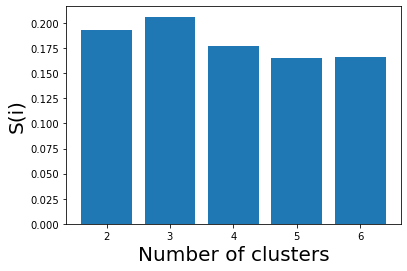

In [23]:
from sklearn.cluster import MiniBatchKMeans

kmm2 = MiniBatchKMeans(n_clusters = 2) 
kmm3 = MiniBatchKMeans(n_clusters = 3) 
kmm4 = MiniBatchKMeans(n_clusters = 4) 
kmm5 = MiniBatchKMeans(n_clusters = 5) 
kmm6 = MiniBatchKMeans(n_clusters = 6)

k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append(silhouette_score(df, kmm2.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, kmm3.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, kmm4.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, kmm5.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, kmm6.fit_predict(df))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

# 3 clusters provides the highest silhoutte scores
# Source code: https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

In [24]:
# create kmm dataset
df_kmm = df

# define the model
model = MiniBatchKMeans(n_clusters = 2)

# fit the model
model.fit(df_kmm)

# assign a cluster to each example
yhat = model.predict(df_kmm)

# retrieve unique clusters
clusters = unique(yhat)
print("Clusters: ", clusters)

# add cluster do dataset
df_kmm["Cluster"] = yhat
print(df_kmm.head())

# k mini-means found 2 clusters

Clusters:  [0 1]
          0         1         2         3         4         5         6  \
0 -0.213124  0.152247  0.039678 -0.198728 -0.233888  0.337225  0.334643   
1 -0.083991  0.187453  0.048853  0.198459 -0.237766 -0.204647  0.412026   
2 -0.285846  0.389647  0.101548  0.412524 -0.076791  0.004095  0.051147   
3 -0.375871  0.337310  0.087908 -0.440291  0.069037  0.003545  0.044277   
4 -0.232728 -0.317984  0.054430 -0.272615  0.602117 -0.228010  0.027415   

          7         8         9  ...        19        20        21        22  \
0 -0.132239 -0.126563 -0.289177  ... -0.055866 -0.057987 -0.059130 -0.055220   
1  0.030915  0.042487  0.053187  ... -0.055669 -0.056655 -0.072804 -0.042010   
2  0.064261  0.088315  0.110557  ... -0.115717 -0.117766 -0.119915 -0.006321   
3  0.055629  0.076452  0.095707  ... -0.095454 -0.099295 -0.101931 -0.098968   
4 -0.181405  0.047337  0.059259  ...  0.069490  0.068263 -0.069512 -0.065924   

         23        24        25        26        27

---

# Mean shift
Meanshift is falling under the category of a clustering algorithm, in contrast to unsupervised learning, that assigns the data points to the clusters iteratively by shifting points towards the mode. Mode is the highest density of data points in the region (in the context of the Meanshift). As such, it is also known as the Mode-seeking algorithm. Mean-shift algorithm has applications in the field of image processing and computer vision.

Unlike the popular K-Means cluster algorithm, mean-shift does not require specifying the number of clusters in advance. The number of clusters is determined by the algorithm with respect to the data. Meanshift determined that 2 clusters were present

*Knowledge code: https://www.geeksforgeeks.org/ml-mean-shift-clustering/

In [25]:
from sklearn.cluster import MeanShift

# define the model
model = MeanShift()
# fit model and predict clusters
yhat = model.fit_predict(df)
# retrieve unique clusters
clusters = unique(yhat)
print(clusters)

# 2 clusters were identified

[0 1]


---

# OPTICS

OPTICS Clustering stands for Ordering Points To Identify Cluster Structure. It draws inspiration from the DBSCAN clustering algorithm. It adds two more terms to the concepts of DBSCAN clustering. They are:

1. **Core Distance:** It is the minimum value of radius required to classify a given point as a core point. If the given point is not a Core point, then it’s Core Distance is undefined.

2. **Reachability Distance:** It is defined with respect to another data point q(Let). The Reachability distance between a point p and q is the maximum of the Core Distance of p and the Euclidean Distance(or some other distance metric) between p and q. Note that The Reachability Distance is not defined if q is not a Core point.

This clustering technique is different from other clustering techniques in the sense that this technique does not explicitly segment the data into clusters. Instead, it produces a visualization of Reachability distances and uses this visualization to cluster the data. Optics identifed 3 clusters.

*Knowledge Code: https://www.geeksforgeeks.org/ml-optics-clustering-explanation/*

In [26]:
from sklearn.cluster import OPTICS

# define the model
model = OPTICS(eps=0.4, min_samples=54)
# fit model and predict clusters
yhat = model.fit_predict(df)
# retrieve unique clusters
clusters = unique(yhat)
print(clusters) # 3 clusters identified

[-1  0  1]


---

# Spectral Clustering

Spectral clustering is an EDA technique that reduces complex multidimensional datasets into clusters of similar data in rarer dimensions. The main outline is to cluster the all spectrum of unorganized data points into multiple groups based upon their uniqueness “Spectral clustering is one of the most popular forms of multivariate statistical analysis” ‘Spectral Clustering uses the connectivity approach to clustering’, wherein communities of nodes (i.e. data points) that are connected or immediately next to each other are identified in a graph. The nodes are then mapped to a low-dimensional space that can be easily segregated to form clusters. Spectral Clustering uses information from the eigenvalues (spectrum) of special matrices (i.e. Affinity Matrix, Degree Matrix and Laplacian Matrix) derived from the graph or the data set.

Spectral identified 2 clusters as the optimal grouping. 

*Knowledge Code: https://www.mygreatlearning.com/blog/introduction-to-spectral-clustering/*

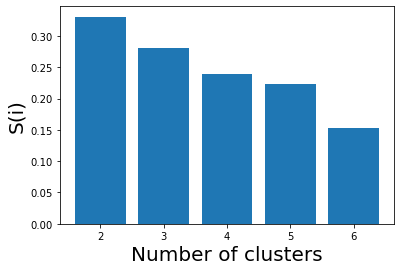

In [27]:
from sklearn.cluster import SpectralClustering

SC2 = SpectralClustering(n_clusters = 2) 
SC3 = SpectralClustering(n_clusters = 3) 
SC4 = SpectralClustering(n_clusters = 4) 
SC5 = SpectralClustering(n_clusters = 5) 
SC6 = SpectralClustering(n_clusters = 6)

k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append(silhouette_score(df, SC2.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, SC3.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, SC4.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, SC5.fit_predict(df))) 
silhouette_scores.append(silhouette_score(df, SC6.fit_predict(df))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

# 2 clusters provides the highest silhoutte scores
# Source code: https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

In [28]:
# create spc dataset
df_sc = df

# define the model
model = SpectralClustering(n_clusters = 2) 

# fit the model
yhat = model.fit_predict(df_sc)

# retrieve unique clusters
clusters = unique(yhat)
print("Clusters: ", clusters)

# add cluster do dataset
df_sc["Cluster"] = yhat
print(df_sc.head())

# spectral with 2 clusters

Clusters:  [0 1]
          0         1         2         3         4         5         6  \
0 -0.213124  0.152247  0.039678 -0.198728 -0.233888  0.337225  0.334643   
1 -0.083991  0.187453  0.048853  0.198459 -0.237766 -0.204647  0.412026   
2 -0.285846  0.389647  0.101548  0.412524 -0.076791  0.004095  0.051147   
3 -0.375871  0.337310  0.087908 -0.440291  0.069037  0.003545  0.044277   
4 -0.232728 -0.317984  0.054430 -0.272615  0.602117 -0.228010  0.027415   

          7         8         9  ...        19        20        21        22  \
0 -0.132239 -0.126563 -0.289177  ... -0.055866 -0.057987 -0.059130 -0.055220   
1  0.030915  0.042487  0.053187  ... -0.055669 -0.056655 -0.072804 -0.042010   
2  0.064261  0.088315  0.110557  ... -0.115717 -0.117766 -0.119915 -0.006321   
3  0.055629  0.076452  0.095707  ... -0.095454 -0.099295 -0.101931 -0.098968   
4 -0.181405  0.047337  0.059259  ...  0.069490  0.068263 -0.069512 -0.065924   

         23        24        25        26        27

---
# Clustering Results

Technique|Clusters|
----|----|
Agglomerative | 2 |
BIRCH | 3 |
DBSCAN | 11 -13 |
K-Means | 2 |
K-Means Mini | 3 |
Meanshift | 2 |
Optics | 3 |
Spectral | 2 |


It is clear that there are 2 to 3 best fit clusters present in the dataset and that the differientator between them appears to be the calculation metric. DBSCAN proved to be the outlier with 11 - 13 clusters. Because we have to manually adjust the eps and minPoints, we anticipate that there was some human error when selecting the thresholds manually. We decided to continue our analysis on the 2 cluster grouping versus the 3 cluster grouping.  Using silhoutte scores, spectral clustering appeared to receive the highest mark at +0.30 indicating that this algorithm was able to best define three distinct groups. We would have still like to have seen a score of 0.5 or higher though which would have indicated much neater groupings. At 0.3 we believe we are still seeing some 'muddy' disinctions. Our results are below. 


---
# Model Evaluation Conclusion:

We conclude that **our winner** after further analysis of the distinction between the groups **is 3 clusters**. Based off of the evaluation metrics for the number of clusters, we ran our analysis for 2 and 3 k-means clusters. We used k-means clustering within our analysis results because it has become somewhat of an industry standard for clustering. When analyzing the 2 clustered model we found that the data was very skewed on one cluster with a 96/4% split. This split of the clusters did not make sense to implement in a business case because the second cluster of 4% of users is too small of a segmentation in order to see a return of investment on either a marketing or operational campaign. In comparison, the 3 cluster model is able to more equally split the users into even groups. This is better for implementation especially because the audience sizes are a decent size that any marketing/operational testing would be able to reach a equivalent audience power to compare A/B tests against. 

#### 3 K-Means Cluster Analysis:
The main callouts between clusters are that Cluster 1 & 3 are closer in some ways versus Cluster 2. Cluster 1 & 3 have higher credit limits around \\$225-230k, while Cluster 2 is closer to $60k. Cluster 2 has the highest amount of defaults and males in comparison. Cluster 3 differs from Cluster 1 in that even though they have a high credit limit they do not use all of their credit and maintain a low payment balance around 5% of their total credit limit compared to Cluster 1 who use about 64% of their credit limit. An interesting distinction between Cluster 1 & 3 is that Cluster 1 keeps a higher billing balance, meaning they are accruing more interest, which translates to more revenue for the bank. We may watch Cluster 1, while they are a higher risk user of defaulting, we want to make sure that they continue to make their payments. 

* Cluster 1 = __Faux Felicity__ - These users might be spending outside their means as they use the highest amount of their credit balance at 64%. This group makes up the middle group default percentage of 17%. Not knowing their income or credit history, proves to be difficult when creating a full view of this user. 
* Cluster 2 = __Newbie Nathan__ - having a slightly younger average age with more high school graduates and males  in this group, they probably have the least amount of education on credit cards and how to pay off debts. They use 56% of their total credit balance which averages around \\$60k. This group also has the highest amount of users who default, 34%. \\
* Cluster 3 = __Turtle Tom__ - slow and steady wins the race. This group of users have the highest credit limit, but only use 5% of their CL balance. They also have the lowest amount of defaults at 14%. They keep their bill amount very close to their payment amounts, meaning they probably accrue the least amount interest. 

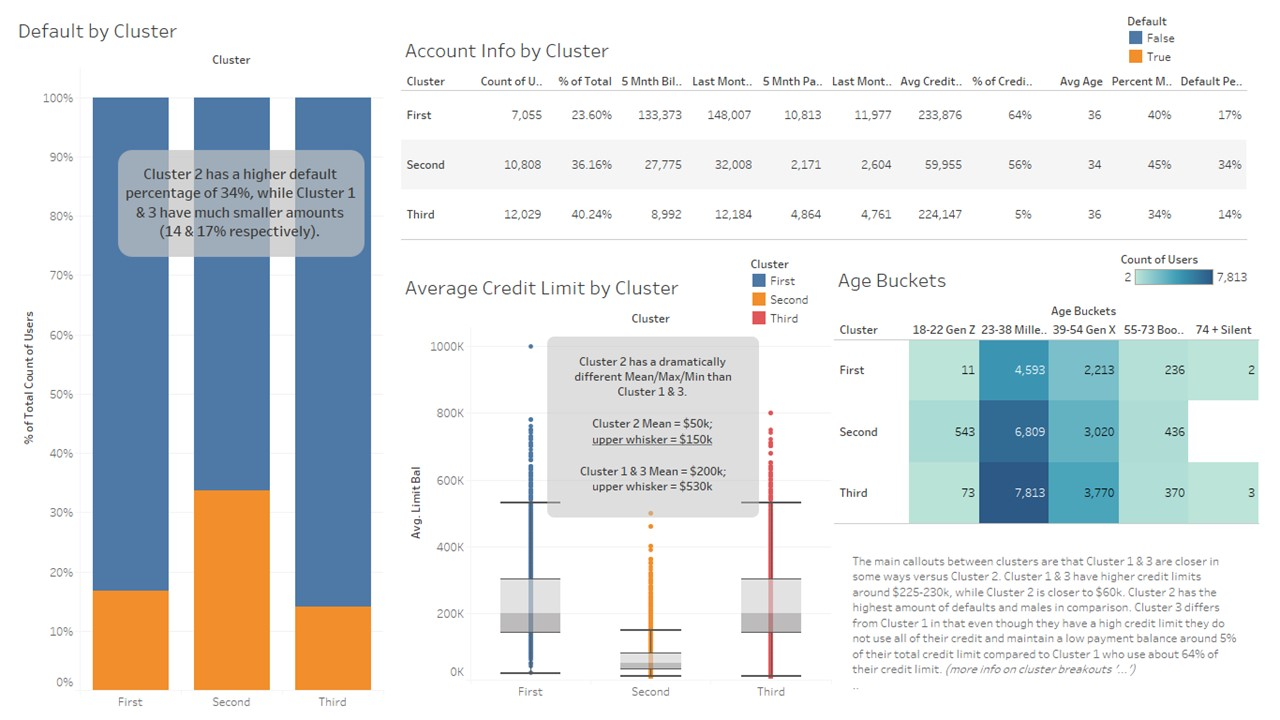

In [8]:
#Executive Summary for 3 Clusters
Image("../img/3Cluster_Summary.jpg")

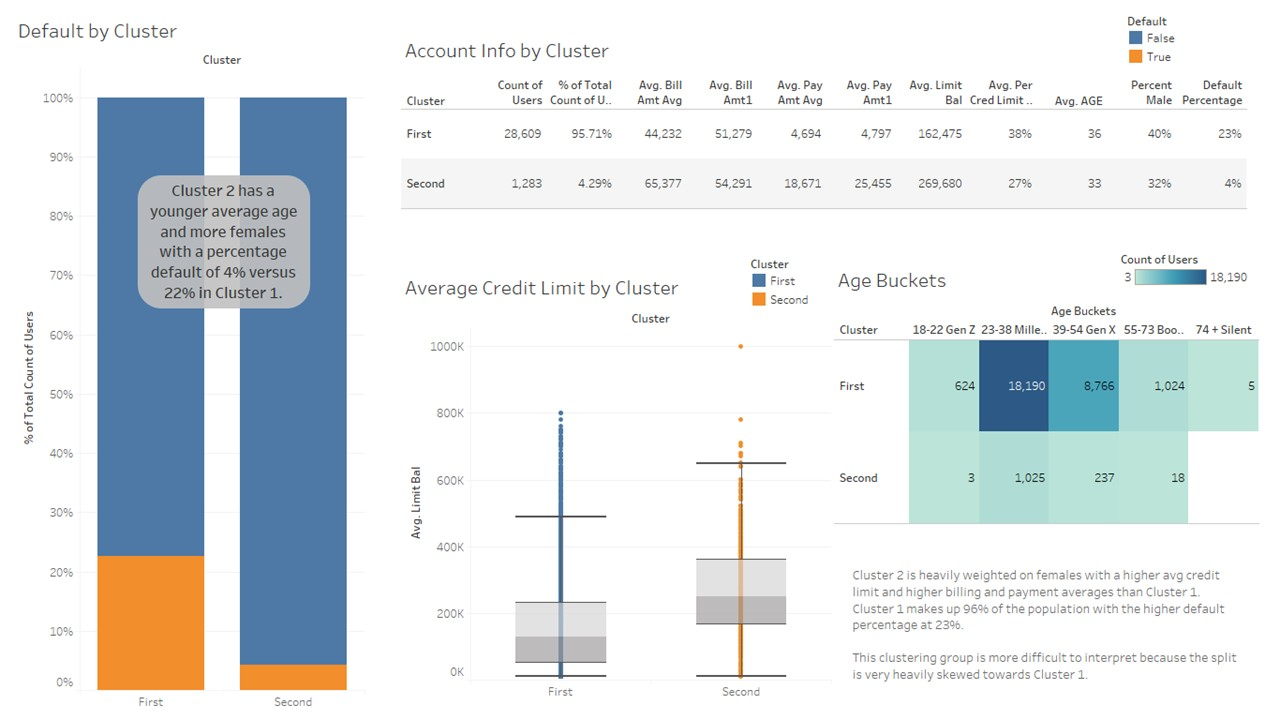

In [7]:
#Executive Summary for 2 Clusters
Image("../img/2Cluster_Summary.jpg")

---
# Deployment (*for clustering*):

Clustering better serves the business question of:  __who are my customers? And, what do they look like?__

The current results are very vague and difficult to gain a holistic view of the bank's customer set. There is not a definitive customer segment that is more likely to default than others. The default percentages ranged fairly close to one another. 

Concluding that the current results from the clustering is informative, yet not actionable. With the current results of the clustering analysis, we would present the findings to the client as 'Phase 1' out of 2, with the caveat that we would like for more customer profile information in order to better implement the findings. 

In 'Phase 2' of this analysis we would request further customer profile information (credit tenure, if a user has defaulted previously, if a user has been contacted by a customer representative within the last 30 days, FICO score, location, income level) and credit transaction level detail (for example, is a user spending more in the mortgage or grocery categories). 

Once 'Phase 2' of the analysis is complete and the clustering is more robust, then the customer segmentations could be used a variety of ways, one of them being leveraged within a customer management system in order to reach out to users that may be identified as high-default risk to share information on how the bank can help them ensure they do not default. Secondly, the customer segmentation could be used within marketing to cross-sell other credit card options within the bank that the user might also fit into depending on their use and credit score. For example, if a customer uses Card A for grocery and travel the bank could cross-sell with marketing materials containing Card B, which has specific travel rewards. Once the customer contacts the bank to show interest in Card B, the bank could also use these customer segmentations to inform and educate the customer more on the grocery cash-back rewards of Card A. 

If we had more of this credit score information on the user, the model would need to be updated at least once a month. The model could be updated when credit statement balances are posted. 
